In [1]:
#importing libraries for model training
import os
import numpy as np
from tensorflow.keras.applications import VGG16 # type: ignore
from tensorflow.keras.applications import InceptionV3 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore


In [7]:
train_dir='./processed_images/train/'
test_dir='./processed_images/test/'

In [8]:

# Initialize the ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize the ImageDataGenerator for testing (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)
print(f"Class labels mapping: {train_generator.class_indices}")


Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Class labels mapping: {'cataract': 0, 'normal': 1}


## Applying Data Augmentation to increase Data Size

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img # type: ignore

# Paths to the folders
train_dir = './processed_images/train/'
output_dir = './augmented_train/'

# Initialize ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augment and save images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)

    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

        # Generate augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_path,
                                  save_prefix=img_name.split('.')[0], save_format='png'):
            i += 1
            if i >= 5:  # Save 5 augmented versions
                break

print(f"Augmented images saved to: {output_dir}")


Augmented images saved to: ./augmented_train/


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img # type: ignore

# Paths to the folders
train_dir = './processed_images/test/'
output_dir = './augmented_test/'

# Initialize ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augment and save images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)

    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

        # Generate augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_path,
                                  save_prefix=img_name.split('.')[0], save_format='png'):
            i += 1
            if i >= 5:  # Save 5 augmented versions
                break

print(f"Augmented images saved to: {output_dir}")


In [9]:
train_dir='./augmented_train/'
test_dir='./augmented_test/'
# Create training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)
print(f"Class labels mapping: {train_generator.class_indices}")


Found 2455 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Class labels mapping: {'cataract': 0, 'normal': 1}


In [10]:
# Input shape since VGG16 is used
input_shape = (224, 224, 3)

# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model for the classification task of cataract images
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_v10.keras', monitor='val_loss', save_best_only=True)

# Train the model with frozen base layers
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)



In [13]:
# Load the best model from training
model.load_weights('best_model_v10.keras')

# Fine-tune the model: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Train model on the data again to finetune last few layers
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuned layers
history_fine_tuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.8936 - loss: 0.5494 - val_accuracy: 0.9524 - val_loss: 0.3737
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - accuracy: 0.9805 - loss: 0.2987 - val_accuracy: 0.9594 - val_loss: 0.3829
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 434s 6s/step - accuracy: 0.9923 - loss: 0.2302 - val_accuracy: 0.9720 - val_loss: 0.2842
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.9882 - loss: 0.2084 - val_accuracy: 0.9664 - val_loss: 0.2992
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step - accuracy: 0.9919 - loss: 0.1738 - val_accuracy: 0.9664 - val_loss: 0.2531
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 438s 6s/step - accuracy: 0.9989 - loss: 0.1304 - val_accuracy: 0.9636 - val_loss: 0.3068
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 432s 6s/step - accuracy: 0.9940 - loss: 0.1241 - val_accuracy: 0.9692 - val_loss: 0.2876
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 549s 7s/step - accuracy: 0.9938 - loss: 0.1029 - val_accuracy: 0.9748 - v

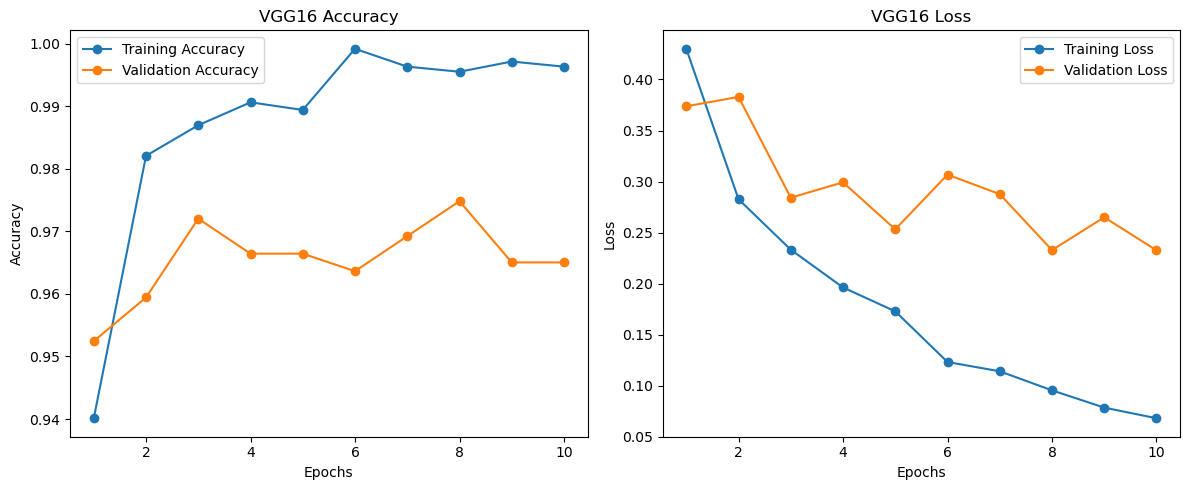

In [14]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title_prefix="Model"):
    """
    Plots the training and validation loss and accuracy.

    Parameters:
        history: The history object from model training.
        title_prefix: Prefix for the plot titles.
    """
    # Get training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for VGG16 model
plot_loss_accuracy(history_fine_tuning, title_prefix="VGG16")



In [15]:
# Save the final model (architecture + weights) in .keras format
final_model_dir = os.path.join('..', 'Phase1') 
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)  

final_model_path = os.path.join(final_model_dir, 'final_model.keras')
model.save(final_model_path)

In [16]:
model.evaluate(test_generator, steps=len(test_generator))

23/23 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.9631 - loss: 0.2608


[0.23257915675640106, 0.9650349617004395]

23/23 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step


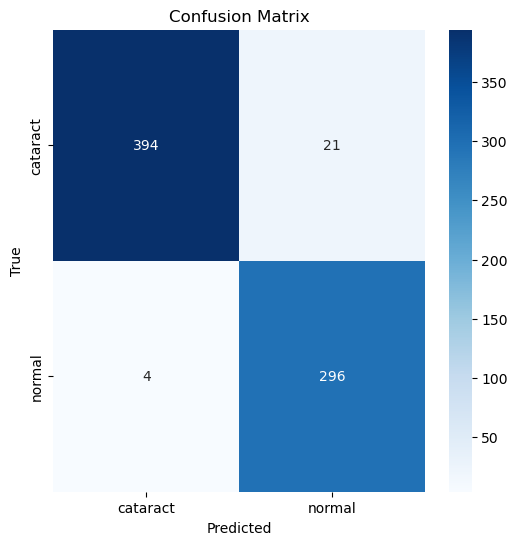

Classification Report:
              precision    recall  f1-score   support

    cataract       0.99      0.95      0.97       415
      normal       0.93      0.99      0.96       300

    accuracy                           0.97       715
   macro avg       0.96      0.97      0.96       715
weighted avg       0.97      0.97      0.97       715



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicting the labels for the test dataset
test_generator.reset()  
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary (0 or 1) based on threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Get the true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image # type: ignore

def load_and_predict_image(image_path, target_size=(224, 224)):
    
    # Load the image from the given path
    img = image.load_img(image_path, target_size=target_size)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image to match model input requirements
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = (predictions > 0.5).astype(int)
    print(f"Predicted class: {'Normal' if predicted_class[0][0] == 1 else 'Cataract'}")
    return predicted_class[0][0]


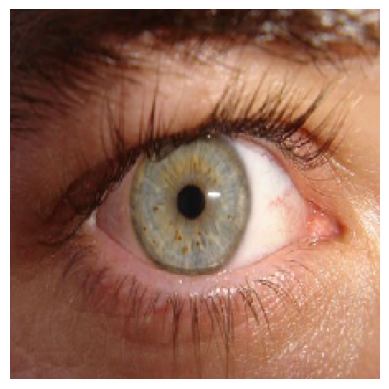

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted class: Normal


1

In [19]:
image_path = './processed_images/test/normal/image_254.png'
load_and_predict_image(image_path)

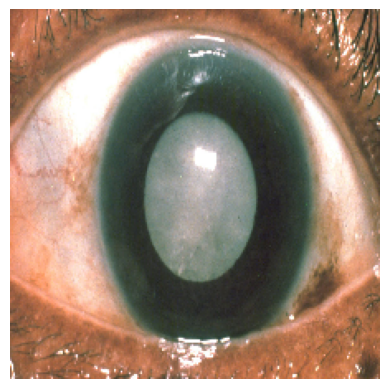

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predicted class: Cataract


0

In [20]:
image_path = './processed_images/test/cataract/image_246.png'
load_and_predict_image(image_path)

## InceptionV3 Model

In [21]:
# Input shape since VGG16 is used
input_shape = (224, 224, 3)

# Load the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model for the classification task of cataract images
inceptionmodel = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
inceptionmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
inceptionmodel.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,356,641 (108.17 MB)

 Trainable params: 6,553,857 (25.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [24]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('inception_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with frozen base layers
history1 = inceptionmodel.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 952ms/step - accuracy: 0.8026 - loss: 3.0110 - val_accuracy: 0.9161 - val_loss: 2.2011
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9257 - loss: 2.0892 - val_accuracy: 0.9217 - val_loss: 1.8088
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9231 - loss: 1.7542 - val_accuracy: 0.9441 - val_loss: 1.5210
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9386 - loss: 1.4710 - val_accuracy: 0.9385 - val_loss: 1.3118
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9415 - loss: 1.2595 - val_accuracy: 0.9357 - val_loss: 1.1605
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9502 - loss: 1.0903 - val_accuracy: 0.9385 - val_loss: 1.0043
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9499 - loss: 0.9587 - val_accuracy: 0.9385 - val_loss: 0.9004
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9520 - loss: 0.8656 - val_accuracy: 0.9441 - 

In [25]:
# Load the best model from training
inceptionmodel.load_weights('inception_model.keras')

# Fine-tune the model: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Train model on the data again to finetune last few layers
inceptionmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuned layers
history_fine_tuning1 = inceptionmodel.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9622 - loss: 0.2805 - val_accuracy: 0.9497 - val_loss: 0.2811
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9588 - loss: 0.2532 - val_accuracy: 0.9469 - val_loss: 0.2872
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9651 - loss: 0.2365 - val_accuracy: 0.9510 - val_loss: 0.2753
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9642 - loss: 0.2233 - val_accuracy: 0.9469 - val_loss: 0.2532
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9676 - loss: 0.2093 - val_accuracy: 0.9469 - val_loss: 0.2618
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9662 - loss: 0.2187 - val_accuracy: 0.9538 - val_loss: 0.2544
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9713 - loss: 0.1930 - val_accuracy: 0.9552 - val_loss: 0.2444
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9685 - loss: 0.1997 - val_accuracy: 0.9469 - va

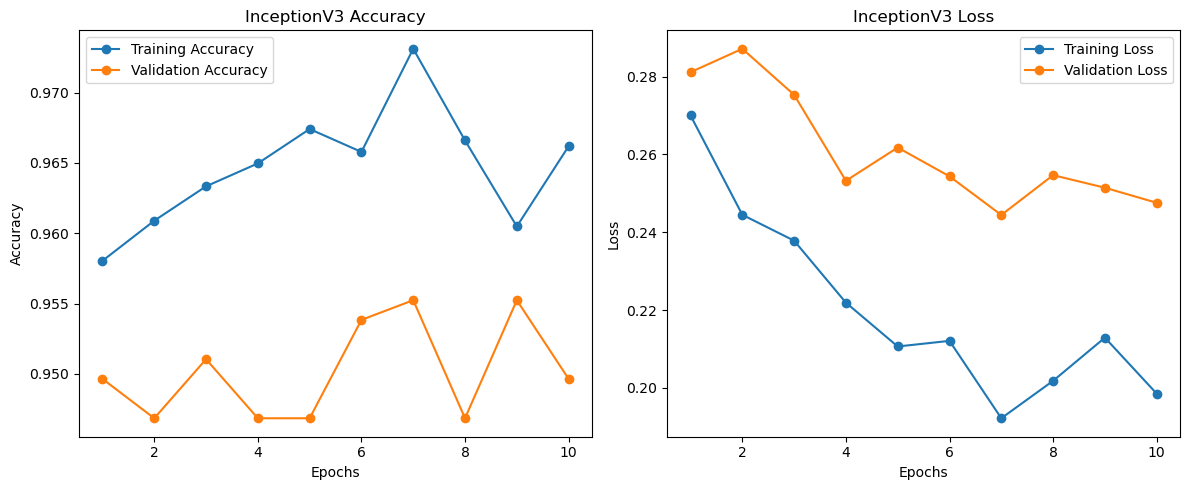

In [26]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title_prefix="Model"):
    """
    Plots the training and validation loss and accuracy.

    Parameters:
        history: The history object from model training.
        title_prefix: Prefix for the plot titles.
    """
    # Get training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot for InceptionV3 model
plot_loss_accuracy(history_fine_tuning1, title_prefix="InceptionV3")


In [27]:
# Save the final model (architecture + weights) in .keras format
final_model_dir = os.path.join('..', 'Phase1') 
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)  

final_model_path = os.path.join(final_model_dir, 'inception_model.keras')
model.save(final_model_path)

In [28]:
inceptionmodel.evaluate(test_generator, steps=len(test_generator))

23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 854ms/step - accuracy: 0.9597 - loss: 0.2203


[0.24444879591464996, 0.955244779586792]

23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 795ms/step


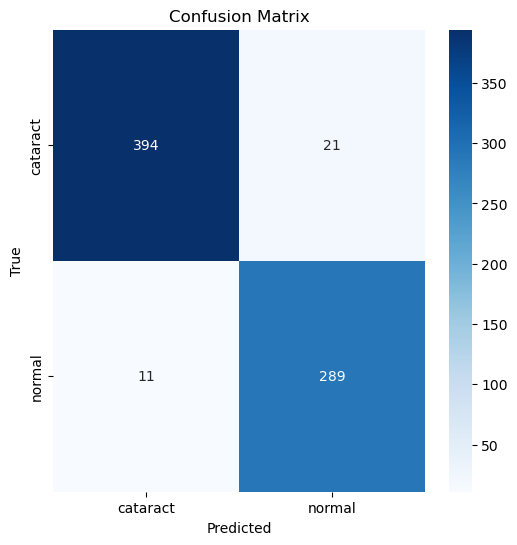

Classification Report:
              precision    recall  f1-score   support

    cataract       0.97      0.95      0.96       415
      normal       0.93      0.96      0.95       300

    accuracy                           0.96       715
   macro avg       0.95      0.96      0.95       715
weighted avg       0.96      0.96      0.96       715



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicting the labels for the test dataset
test_generator.reset()  # To reset the generator for evaluation
predictions = inceptionmodel.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary (0 or 1) based on threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Get the true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image # type: ignore

def load_and_predict_image(image_path, target_size=(224, 224)):
    
    # Load the image from the given path
    img = image.load_img(image_path, target_size=target_size)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image to match model input requirements
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    
    # Predict the class
    predictions = inceptionmodel.predict(img_array)
    predicted_class = (predictions > 0.5).astype(int)
    print(f"Predicted class: {'Normal' if predicted_class[0][0] == 1 else 'Cataract'}")
    return predicted_class[0][0]


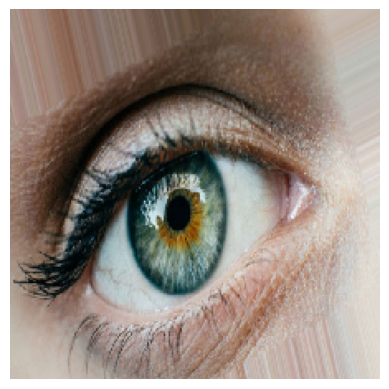

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Predicted class: Normal


1

In [33]:
image_path = 'augmented_test/normal/image_246_0_6179.png'
load_and_predict_image(image_path)

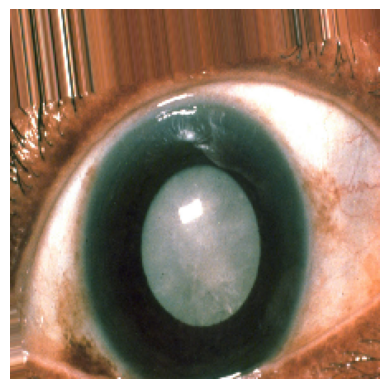

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted class: Cataract


0

In [34]:
image_path = './augmented_test/cataract/image_246_0_2850.png'
load_and_predict_image(image_path)

In [35]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to compute metrics for each model
def get_classification_metrics(model, test_generator):
    true_labels = test_generator.classes
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_labels = (predictions > 0.5).astype(int)

    # Compute classification metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

# Get the metrics for VGG16 model
vgg16_metrics = get_classification_metrics(model, test_generator)

# Get the metrics for InceptionV3 model
inceptionv3_metrics = get_classification_metrics(inceptionmodel, test_generator)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Model': ['VGG16', 'InceptionV3'],
    'Accuracy': [vgg16_metrics[0], inceptionv3_metrics[0]],
    'Precision': [vgg16_metrics[1], inceptionv3_metrics[1]],
    'Recall': [vgg16_metrics[2], inceptionv3_metrics[2]],
    'F1-Score': [vgg16_metrics[3], inceptionv3_metrics[3]]
})

# Display the metrics
print(metrics_df)


23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step
         Model  Accuracy  Precision    Recall  F1-Score
0        VGG16  0.965035   0.933754  0.986667  0.959481
1  InceptionV3  0.955245   0.932258  0.963333  0.947541


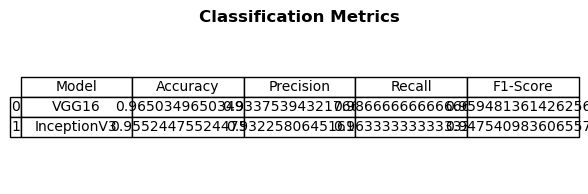

In [36]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Visualize the metrics table
def visualize_metrics_table(metrics_df):
    fig, ax = plt.subplots(figsize=(6, 2)) 
    ax.axis('off')  
    ax.axis('tight') 
    tbl = table(ax, metrics_df, loc='center', cellLoc='center')  
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)  # Set the font size of the table
    tbl.scale(1.2, 1.2)  
    plt.title("Classification Metrics", fontsize=12, weight='bold')
    plt.show()

# Visualize the DataFrame
visualize_metrics_table(metrics_df)
